# Feature Engineering & Balancing Pipeline

This notebook:
1. Scans the raw dataset (`data/raw/FullDataEmoSet`) and reports class distribution.
2. Defines a target balancing strategy (max/median/custom).
3. Performs augmentation to oversample minority classes up to the target.
4. Optionally undersamples majority classes (disabled by default).
5. Resizes all images to a target size (default 224x224) in-place or to an output folder.
6. Computes per-channel pixel statistics (mean/std) before and after.
7. Provides sanity checks and sample visualizations.
8. Splits into train/val/test and writes `train.csv`, `val.csv`, `test.csv`, plus `status.csv` and `map_labels.csv`.
9. Visulaze the Data distributions with train, val, test

Safety: Heavy operations (aug/resize/write) are disabled by default via `RUN_WRITE=False`. Enable after reviewing the plan.


In [24]:
# Config
from pathlib import Path

RAW_ROOT = Path("../data/raw/FullDataEmoSet").resolve()
WORK_ROOT = Path("../data/processed/FullDataEmoSet_balanced").resolve()   # output (set to RAW_ROOT for in-place)
IN_PLACE = False  # if True, writes into RAW_ROOT (use with care)
RUN_WRITE = True  # master switch for file writes (augment/resize/csvs)

# Balancing strategy: 'max', 'median', or a dict like {label: target_count}
BALANCE_STRATEGY = 'max'
UNDERSAMPLE = False  # optional undersample majority classes to target

# Augmentation settings
AUG_PER_IMAGE_LIMIT = 4  # max augmented variants per original

# Resizing
TARGET_SIZE = (224, 224)
INTERPOLATION = 'bilinear'  # or 'nearest', 'bicubic'

# Split ratios
TRAIN_PCT, VAL_PCT, TEST_PCT = 0.7, 0.15, 0.15

# Random seed
SEED = 42

assert abs(TRAIN_PCT + VAL_PCT + TEST_PCT - 1.0) < 1e-6
assert RAW_ROOT.exists(), f"Missing raw dataset: {RAW_ROOT}"
OUT_ROOT = RAW_ROOT if IN_PLACE else WORK_ROOT
OUT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"RAW_ROOT={RAW_ROOT}\nOUT_ROOT={OUT_ROOT}\nRUN_WRITE={RUN_WRITE}")

RAW_ROOT=/Users/lahirumunasinghe/Documents/DataScience/ann-visual-emotion/data/raw/FullDataEmoSet
OUT_ROOT=/Users/lahirumunasinghe/Documents/DataScience/ann-visual-emotion/data/processed/FullDataEmoSet_balanced
RUN_WRITE=True


In [14]:
# Scan dataset
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".gif"}

class_dirs = [p for p in RAW_ROOT.iterdir() if p.is_dir()]
labels = sorted([p.name for p in class_dirs])

records = []
for lab in labels:
    for p in (RAW_ROOT / lab).rglob('*'):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            records.append({"path": str(p), "label": lab})

df = pd.DataFrame(records)
print(f"Found {len(labels)} classes, {len(df)} images")

class_counts = df['label'].value_counts().sort_index()
percentages = (class_counts / class_counts.sum() * 100).round(2)
print("\nCounts per class:\n", class_counts)
print("\nPercentages per class (%):\n", percentages)
print("\nDescriptive stats of counts:\n", class_counts.describe())

Found 6 classes, 43640 images

Counts per class:
 label
angry         4953
fearful       4245
happy        13365
neutral       8324
sad           7817
surprised     4936
Name: count, dtype: int64

Percentages per class (%):
 label
angry        11.35
fearful       9.73
happy        30.63
neutral      19.07
sad          17.91
surprised    11.31
Name: count, dtype: float64

Descriptive stats of counts:
 count        6.000000
mean      7273.333333
std       3421.279098
min       4245.000000
25%       4940.250000
50%       6385.000000
75%       8197.250000
max      13365.000000
Name: count, dtype: float64


In [15]:
# Per-channel pixel statistics (before aug/resize)
from itertools import islice

SAMPLE_PER_CLASS = 200  # adjust for speed vs. fidelity
random.seed(SEED)

sample_paths = []
for lab in labels:
    files = df[df.label==lab]['path'].tolist()
    random.shuffle(files)
    sample_paths.extend(files[:SAMPLE_PER_CLASS])

means = []
stds = []
for p in sample_paths:
    try:
        img = Image.open(p).convert('RGB')
        arr = np.asarray(img).astype(np.float32) / 255.0
        means.append(arr.mean(axis=(0,1)))
        stds.append(arr.std(axis=(0,1)))
    except Exception:
        pass

means = np.array(means)
stds = np.array(stds)
pre_mean = means.mean(axis=0) if len(means) else np.array([np.nan, np.nan, np.nan])
pre_std  = stds.mean(axis=0) if len(stds) else np.array([np.nan, np.nan, np.nan])
print("Pre-augmentation/resizing RGB mean:", pre_mean)
print("Pre-augmentation/resizing RGB std:", pre_std)

Pre-augmentation/resizing RGB mean: [0.50525904 0.50525904 0.50525904]
Pre-augmentation/resizing RGB std: [0.21054912 0.21054912 0.21054912]


In [16]:
# Balancing strategy and augmentation transforms
import math
from typing import Dict, List

import numpy as np
from PIL import Image, ImageEnhance, ImageOps

rng = np.random.default_rng(SEED)

# Decide target per class
if isinstance(BALANCE_STRATEGY, dict):
    target_per_class: Dict[str, int] = {lab: int(BALANCE_STRATEGY.get(lab, class_counts.max())) for lab in labels}
elif BALANCE_STRATEGY == 'max':
    target = int(class_counts.max())
    target_per_class = {lab: target for lab in labels}
elif BALANCE_STRATEGY == 'median':
    target = int(class_counts.median())
    target_per_class = {lab: target for lab in labels}
else:
    raise ValueError("BALANCE_STRATEGY must be 'max', 'median', or dict")

print("Target per class:", target_per_class)

# Simple PIL augmentations
def augment_image(img: Image.Image) -> Image.Image:
    choice = rng.choice(["flip_h", "flip_v", "rotate", "brightness", "contrast", "sharpness"], p=[0.2,0.1,0.2,0.2,0.2,0.1])
    if choice == "flip_h":
        return ImageOps.mirror(img)
    if choice == "flip_v":
        return ImageOps.flip(img)
    if choice == "rotate":
        angle = rng.integers(-20, 21)
        return img.rotate(int(angle), resample=Image.BILINEAR, expand=False)
    if choice == "brightness":
        factor = float(rng.uniform(0.7, 1.3))
        return ImageEnhance.Brightness(img).enhance(factor)
    if choice == "contrast":
        factor = float(rng.uniform(0.7, 1.3))
        return ImageEnhance.Contrast(img).enhance(factor)
    if choice == "sharpness":
        factor = float(rng.uniform(0.7, 1.5))
        return ImageEnhance.Sharpness(img).enhance(factor)
    return img

Target per class: {'angry': 13365, 'fearful': 13365, 'happy': 13365, 'neutral': 13365, 'sad': 13365, 'surprised': 13365}


In [25]:
# Augment and resize to OUT_ROOT
import shutil
from tqdm import tqdm
from itertools import cycle

interp_map = {
    'nearest': Image.NEAREST,
    'bilinear': Image.BILINEAR,
    'bicubic': Image.BICUBIC,
}
RESAMPLE = interp_map.get(INTERPOLATION, Image.BILINEAR)

# Prepare output dirs
for lab in labels:
    (OUT_ROOT / lab).mkdir(parents=True, exist_ok=True)

post_records = []

for lab in labels:
    src_files = df[df.label==lab]['path'].tolist()
    target_n = target_per_class[lab]
    current_n = len(src_files)
    need = max(target_n - current_n, 0)
    do_undersample = UNDERSAMPLE and current_n > target_n

    # base copy/resize originals
    for p in tqdm(src_files, desc=f"Copy/resize originals: {lab}"):
        src = Path(p)
        rel_name = src.name
        dst = (OUT_ROOT / lab / rel_name)
        if RUN_WRITE:
            try:
                img = Image.open(src).convert('RGB')
                img = img.resize(TARGET_SIZE, resample=RESAMPLE)
                img.save(dst)
            except Exception:
                continue
        post_records.append({"path": str(dst), "label": lab, "origin": str(src), "aug": 0})

    # oversample with augmentation using a cycle over originals
    if need > 0:
        per_src_created = {}
        created = 0
        for src_path in tqdm(cycle(src_files), total=need, desc=f"Augment: {lab}"):
            if created >= need:
                break
            cnt = per_src_created.get(src_path, 0)
            if cnt >= AUG_PER_IMAGE_LIMIT:
                continue
            try:
                img = Image.open(src_path).convert('RGB')
            except Exception:
                per_src_created[src_path] = cnt + 1  # skip problematic file
                continue
            aug_img = augment_image(img)
            src = Path(src_path)
            aug_name = f"{src.stem}_aug{created:05d}{src.suffix}"
            dst = (OUT_ROOT / lab / aug_name)
            if RUN_WRITE:
                try:
                    aug_img = aug_img.resize(TARGET_SIZE, resample=RESAMPLE)
                    aug_img.save(dst)
                except Exception:
                    per_src_created[src_path] = cnt + 1
                    continue
            post_records.append({"path": str(dst), "label": lab, "origin": str(src), "aug": 1})
            per_src_created[src_path] = cnt + 1
            created += 1

    # optional undersample (delete extras or skip copying); here we skip recording extras
    if do_undersample:
        # Since we write to OUT_ROOT, to undersample we'd simply not copy extras.
        pass

post_df = pd.DataFrame(post_records)
print("Post dataset count (planned):", len(post_df))

Augment: surprised: 100%|██████████| 8429/8429 [00:21<00:00, 397.99it/s]


Post dataset count (planned): 80190


Post-augmentation/resizing RGB mean: [0.49907035 0.49907035 0.49907035]
Post-augmentation/resizing RGB std: [0.2048723 0.2048723 0.2048723]


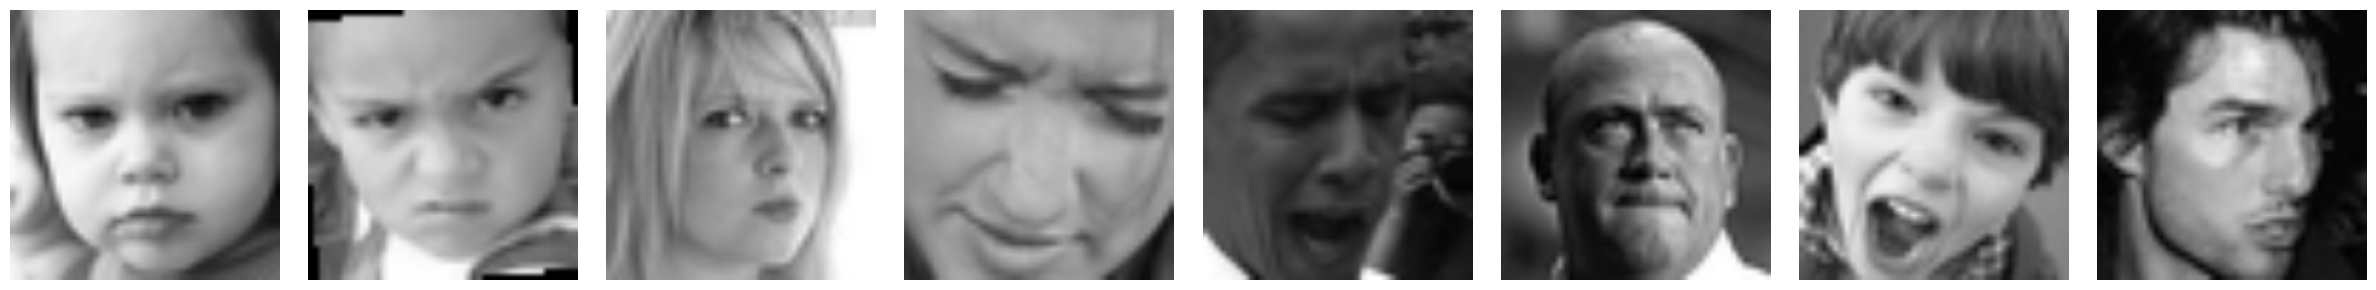

In [26]:
# Per-channel pixel statistics AFTER aug/resize and quick visualization
import matplotlib.pyplot as plt

sample_paths2 = []
for lab in labels:
    files = (OUT_ROOT / lab).glob('*')
    files = [str(p) for p in files if p.is_file() and p.suffix.lower() in IMG_EXTS]
    random.shuffle(files)
    sample_paths2.extend(files[:SAMPLE_PER_CLASS])

means2, stds2 = [], []
for p in sample_paths2:
    try:
        img = Image.open(p).convert('RGB')
        arr = np.asarray(img).astype(np.float32) / 255.0
        means2.append(arr.mean(axis=(0,1)))
        stds2.append(arr.std(axis=(0,1)))
    except Exception:
        pass

means2 = np.array(means2)
stds2 = np.array(stds2)
post_mean = means2.mean(axis=0) if len(means2) else np.array([np.nan, np.nan, np.nan])
post_std  = stds2.mean(axis=0) if len(stds2) else np.array([np.nan, np.nan, np.nan])

print("Post-augmentation/resizing RGB mean:", post_mean)
print("Post-augmentation/resizing RGB std:", post_std)

# Visual sanity check
n_show = min(8, len(sample_paths2))
if n_show > 0:
    fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
    if n_show == 1:
        axes = [axes]
    for i, p in enumerate(sample_paths2[:n_show]):
        img = Image.open(p).convert('RGB')
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images found in OUT_ROOT yet (RUN_WRITE=False). Enable writes to generate outputs.")

In [30]:
# Train/Val/Test split and CSV exports
from sklearn.model_selection import train_test_split

# Build final file list; prefer OUT_ROOT, otherwise fall back to RAW_ROOT (demo only)
final_records = []
base = OUT_ROOT
has_any = False
for lab in labels:
    files = [p for p in (base / lab).glob('*') if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if files:
        has_any = True
    for p in files:
        final_records.append({"path": str(p), "label": lab})

if not has_any:
    print("No generated images in OUT_ROOT — falling back to RAW_ROOT for splitting preview.")
    final_records = []
    for lab in labels:
        files = [p for p in (RAW_ROOT / lab).glob('*') if p.is_file() and p.suffix.lower() in IMG_EXTS]
        for p in files:
            final_records.append({"path": str(p), "label": lab})

final_df = pd.DataFrame(final_records)

train_df, temp_df = train_test_split(final_df, test_size=(1-TRAIN_PCT), stratify=final_df['label'], random_state=SEED)
val_rel = VAL_PCT / (VAL_PCT + TEST_PCT)
val_df, test_df = train_test_split(temp_df, test_size=(1-val_rel), stratify=temp_df['label'], random_state=SEED)

print({"train": len(train_df), "val": len(val_df), "test": len(test_df)})

# Prepare output CSV folder
CSV_DIR = OUT_ROOT / ".." / "EmoSet_splits"
CSV_DIR = CSV_DIR.resolve()
CSV_DIR.mkdir(parents=True, exist_ok=True)

if RUN_WRITE and has_any:
    import json
    import shutil
    from datetime import datetime, timezone

    # Destination for container-friendly dataset copy referenced by CSVs
    DEST_IMG_ROOT = CSV_DIR / 'raw_balanced'
    for lab in labels:
        (DEST_IMG_ROOT / lab).mkdir(parents=True, exist_ok=True)

    # Copy all balanced files into DEST_IMG_ROOT to match desired path layout
    for rec in final_records:
        src = Path(rec['path'])
        lab = rec['label']
        dst = DEST_IMG_ROOT / lab / src.name
        if not dst.exists():
            try:
                shutil.copy2(src, dst)
            except Exception:
                # Skip problematic file
                continue

    # Helper to map to container mount path
    def to_mount_path(lab: str, filename: str) -> str:
        return f"/data/processed/EmoSet_splits/raw_balanced/{lab}/{filename}"

    # Remap CSV paths to container paths
    def remap_paths(df_):
        df_ = df_.copy()
        df_['path'] = df_.apply(lambda r: to_mount_path(r['label'], Path(r['path']).name), axis=1)
        return df_

    train_df_out = remap_paths(train_df)
    val_df_out = remap_paths(val_df)
    test_df_out = remap_paths(test_df)

    # Write CSVs
    train_df_out.to_csv(CSV_DIR / 'train.csv', index=False)
    val_df_out.to_csv(CSV_DIR / 'val.csv', index=False)
    test_df_out.to_csv(CSV_DIR / 'test.csv', index=False)

    # Also keep the simple status.csv (per-class target vs actual in OUT_ROOT)
    status_rows = []
    actual_counts = final_df['label'].value_counts().to_dict()
    for lab in labels:
        actual = int(actual_counts.get(lab, 0))
        status_rows.append({
            'label': lab,
            'target': target_per_class[lab],
            'actual': actual
        })
    pd.DataFrame(status_rows).to_csv(CSV_DIR / 'status.csv', index=False)

    # status.json with the requested structure
    # Overall distribution from OUT_ROOT
    overall_counts = {lab: int(actual_counts.get(lab, 0)) for lab in sorted(labels)}

    # Split distributions from the remapped DataFrames (same counts)
    def counts_dict(df_):
        return {lab: int(df_[df_['label']==lab].shape[0]) for lab in sorted(labels)}

    splits_dist = {
        'train': counts_dict(train_df),
        'val': counts_dict(val_df),
        'test': counts_dict(test_df),
    }

    total_images = int(sum(overall_counts.values()))
    target_values = list({int(v) for v in target_per_class.values()})
    target_single = int(target_values[0]) if len(target_values) == 1 else None

    status_json = {
        'total_images': total_images,
        'class_distribution': splits_dist,
        'overall_class_distribution': overall_counts,
        'splits_fraction': {
            'train': float(TRAIN_PCT),
            'val': float(VAL_PCT),
            'test': float(TEST_PCT),
        },
        'image_size': {
            'width': int(TARGET_SIZE[0]),
            'height': int(TARGET_SIZE[1]),
        },
        'created_timestamp': datetime.now(timezone.utc).isoformat().replace('+00:00', 'Z'),
        'seed': int(SEED),
        'target_count_per_class': target_single if target_single is not None else target_per_class,
    }

    with open(CSV_DIR / 'status.json', 'w') as f:
        json.dump(status_json, f, indent=2)

print(f"CSV directory: {CSV_DIR}")

{'train': 56132, 'val': 12029, 'test': 12029}
CSV directory: /Users/lahirumunasinghe/Documents/DataScience/ann-visual-emotion/data/processed/EmoSet_splits
CSV directory: /Users/lahirumunasinghe/Documents/DataScience/ann-visual-emotion/data/processed/EmoSet_splits


## Visualize class distributions for train / val / test

The charts below show counts and percentages per class in each split. This works even with `RUN_WRITE=False` (using the temporary split created from the raw dataset).

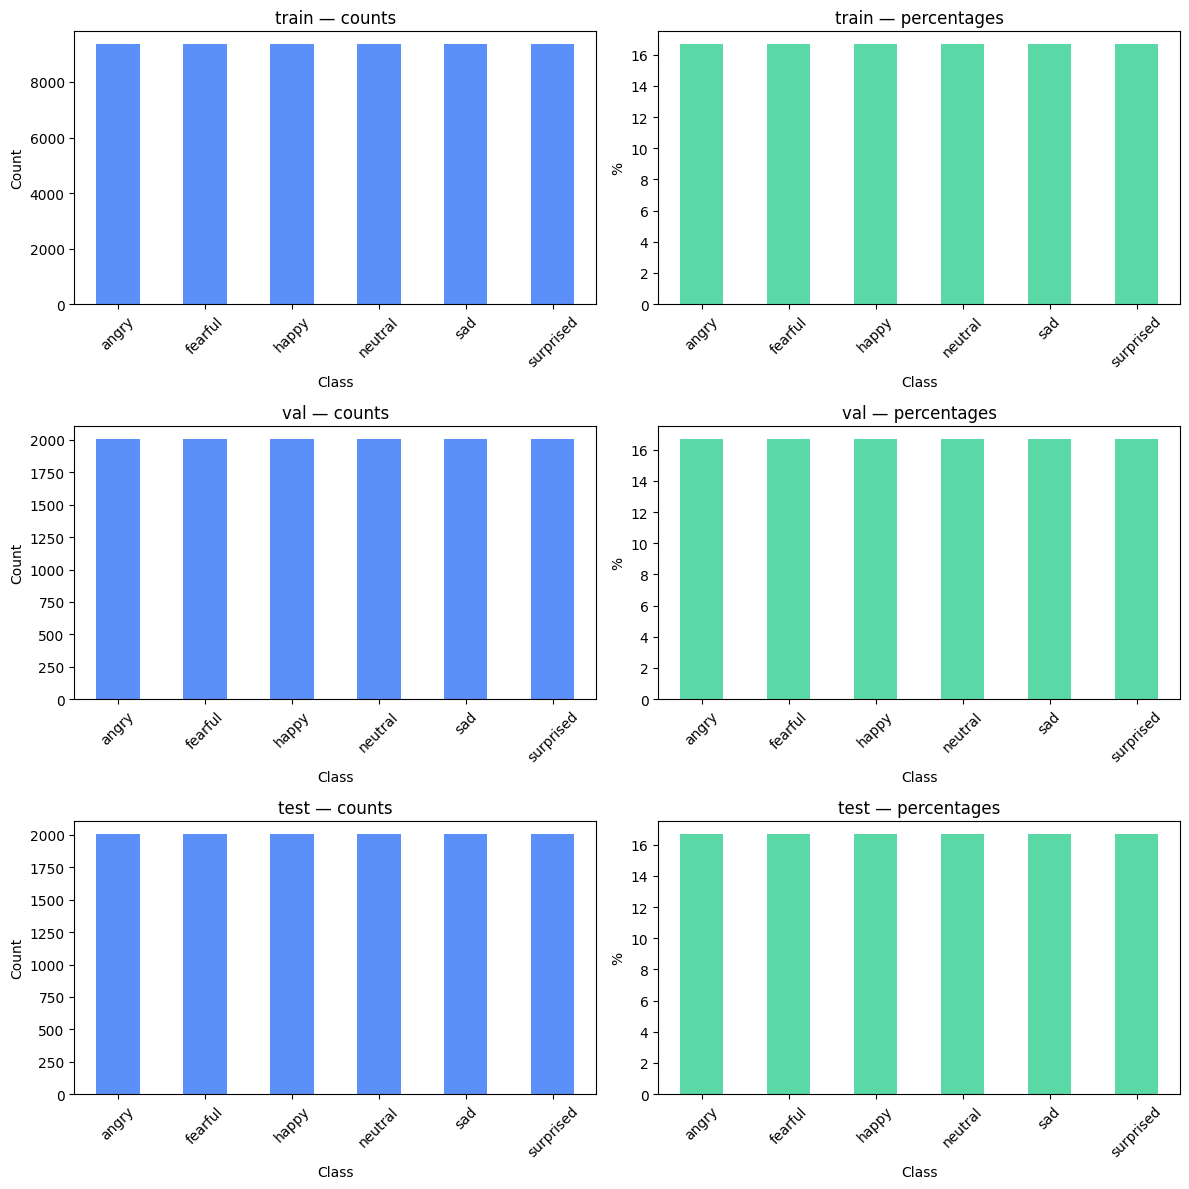

In [28]:
# Plot split distributions (counts and percentages)
import matplotlib.pyplot as plt

assert 'train_df' in globals() and 'val_df' in globals() and 'test_df' in globals(), "Please run the split cell first."

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df,
}

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.ravel()

for i, (name, sdf) in enumerate(splits.items()):
    counts = sdf['label'].value_counts().sort_index()
    pct = (counts / counts.sum() * 100).round(2)

    ax_c = axes[2*i]
    ax_p = axes[2*i + 1]

    counts.plot(kind='bar', ax=ax_c, color='#5B8FF9')
    ax_c.set_title(f'{name} — counts')
    ax_c.set_xlabel('Class'); ax_c.set_ylabel('Count')
    ax_c.tick_params(axis='x', rotation=45)

    pct.plot(kind='bar', ax=ax_p, color='#5AD8A6')
    ax_p.set_title(f'{name} — percentages')
    ax_p.set_xlabel('Class'); ax_p.set_ylabel('%')
    ax_p.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [29]:
# Quick balance check (train/val/test and overall OUT_ROOT) with ±2% tolerance
import pandas as pd
import numpy as np
from pathlib import Path

TOL_PCT = 2.0

def diag(counts: pd.Series, tol_pct: float = TOL_PCT):
    counts = counts.sort_index()
    target = counts.mean()
    diffs = (counts - target) / target * 100
    return {
        'counts': counts.to_dict(),
        'min': int(counts.min()),
        'max': int(counts.max()),
        'mean': float(target),
        'std': float(counts.std(ddof=0)),
        'max_dev_pct': float(diffs.abs().max()),
        'balanced_within_tol_pct': bool(diffs.abs().max() <= tol_pct),
        'tolerance_pct': float(tol_pct),
    }

# Overall OUT_ROOT
overall_records = []
for lab in labels:
    files = [p for p in (OUT_ROOT / lab).glob('*') if p.is_file() and p.suffix.lower() in IMG_EXTS]
    for p in files:
        overall_records.append({'path': str(p), 'label': lab})

if overall_records:
    overall_df2 = pd.DataFrame(overall_records)
    overall_cc2 = overall_df2['label'].value_counts().sort_index()
    print("Overall (OUT_ROOT) balance:")
    print(diag(overall_cc2))
else:
    print("No files in OUT_ROOT to check overall balance.")

# Split-wise
if 'train_df' in globals() and 'val_df' in globals() and 'test_df' in globals():
    for name, sdf in [('train', train_df), ('val', val_df), ('test', test_df)]:
        cc = sdf['label'].value_counts().sort_index()
        print(f"\n{name} balance:")
        print(diag(cc))
else:
    print("train/val/test not available; run the split cell above first.")

Overall (OUT_ROOT) balance:
{'counts': {'angry': 13365, 'fearful': 13365, 'happy': 13365, 'neutral': 13365, 'sad': 13365, 'surprised': 13365}, 'min': 13365, 'max': 13365, 'mean': 13365.0, 'std': 0.0, 'max_dev_pct': 0.0, 'balanced_within_tol_pct': True, 'tolerance_pct': 2.0}

train balance:
{'counts': {'angry': 9356, 'fearful': 9356, 'happy': 9355, 'neutral': 9355, 'sad': 9355, 'surprised': 9355}, 'min': 9355, 'max': 9356, 'mean': 9355.333333333334, 'std': 0.4714045207910317, 'max_dev_pct': 0.007126060001418731, 'balanced_within_tol_pct': True, 'tolerance_pct': 2.0}

val balance:
{'counts': {'angry': 2004, 'fearful': 2005, 'happy': 2005, 'neutral': 2005, 'sad': 2005, 'surprised': 2005}, 'min': 2004, 'max': 2005, 'mean': 2004.8333333333333, 'std': 0.3726779962499649, 'max_dev_pct': 0.0415662149804601, 'balanced_within_tol_pct': True, 'tolerance_pct': 2.0}

test balance:
{'counts': {'angry': 2005, 'fearful': 2004, 'happy': 2005, 'neutral': 2005, 'sad': 2005, 'surprised': 2005}, 'min': 200